Best parameters: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}

Optimized KNN Accuracy: 81.83%

Classification Report:
                                              precision    recall  f1-score   support

                            ASSAULT - SIMPLE       0.82      0.88      0.85      4098
DRUGS - POSSESSION/ SALE/ MANUFACTURING/ USE       0.82      0.95      0.88      4097
                          INVESTIGATE PERSON       0.79      0.59      0.67      4098
                        INVESTIGATE PROPERTY       0.81      0.84      0.83      4098
                         LARCENY SHOPLIFTING       0.84      0.90      0.87      4098
       M/V - LEAVING SCENE - PROPERTY DAMAGE       0.80      0.74      0.77      4098
                    PROPERTY - LOST/ MISSING       0.79      0.90      0.84      4098
                                 SICK ASSIST       0.84      0.64      0.73      4098
                         TOWED MOTOR VEHICLE       0.85      0.87      0.86      4097
                

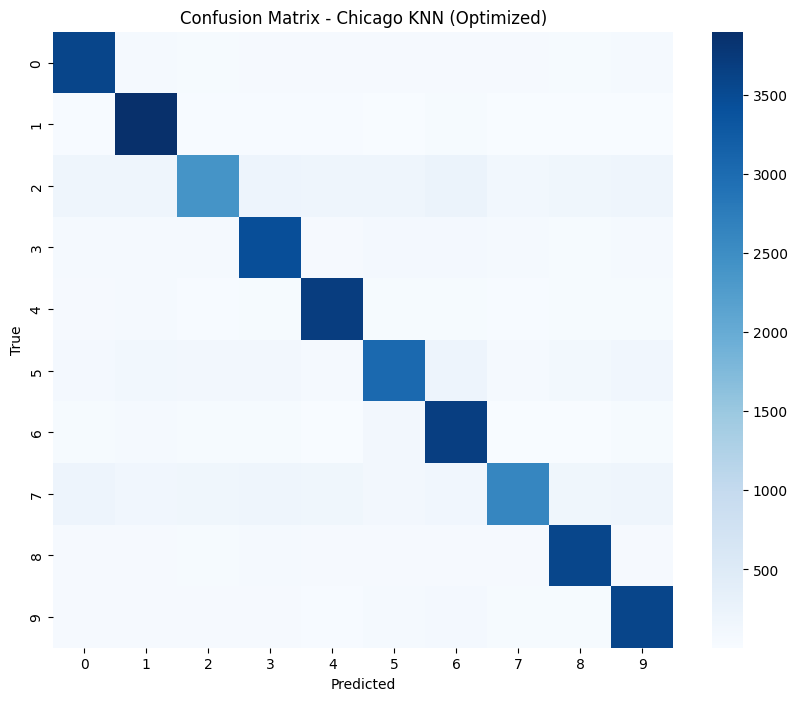

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Load cleaned Chicago dataset ----
df = pd.read_csv("../dataset/boston_crime_features.csv")  # adjust path


# ---- Keep top 10 most frequent crimes ----
top_crimes = df['Crime_Type'].value_counts().nlargest(10).index
df = df[df['Crime_Type'].isin(top_crimes)]

# ---- Select features ----
features = [
    'Latitude', 'Longitude', 'Zone', 'Hour', 'DayOfWeek',
    'IsWeekend', 'Light_Condition', 'Temperature', 'Rain'
]
X = df[features].copy()
y = df['Crime_Type']

# ---- Encode categorical columns (like DayOfWeek or Light_Condition) ----
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# ---- Balance classes ----
df_balanced = pd.concat([
    resample(df[df['Crime_Type'] == c],
             replace=True,
             n_samples=df['Crime_Type'].value_counts().max(),
             random_state=42)
    for c in top_crimes
])
X = df_balanced[features].copy()
y = df_balanced['Crime_Type']

for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# ---- Encode target ----
target_le = LabelEncoder()
y_encoded = target_le.fit_transform(y)

# ---- Scale ----
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- Split ----
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ---- Grid Search ----
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='accuracy', cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

best_knn = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# ---- Train & Evaluate ----
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nOptimized KNN Accuracy: {acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_le.classes_))

# ---- Confusion Matrix ----
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap="Blues", annot=False)
plt.title("Confusion Matrix - Chicago KNN (Optimized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [2]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred, target_names=target_le.classes_))


Random Forest Accuracy: 0.796085704524379
                                              precision    recall  f1-score   support

                            ASSAULT - SIMPLE       0.80      0.81      0.81      4098
DRUGS - POSSESSION/ SALE/ MANUFACTURING/ USE       0.80      0.93      0.86      4097
                          INVESTIGATE PERSON       0.72      0.56      0.63      4098
                        INVESTIGATE PROPERTY       0.82      0.80      0.81      4098
                         LARCENY SHOPLIFTING       0.89      0.93      0.91      4098
       M/V - LEAVING SCENE - PROPERTY DAMAGE       0.76      0.70      0.73      4098
                    PROPERTY - LOST/ MISSING       0.76      0.87      0.81      4098
                                 SICK ASSIST       0.74      0.66      0.70      4098
                         TOWED MOTOR VEHICLE       0.82      0.89      0.85      4097
                                   VANDALISM       0.82      0.80      0.81      4098

          

In [3]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=200,
    objective='multiclass',
    random_state=42
)
lgbm.fit(X_train, y_train)
lgb_pred = lgbm.predict(X_test)

print("LightGBM Accuracy:", accuracy_score(y_test, lgb_pred))
print(classification_report(y_test, lgb_pred, target_names=target_le.classes_))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 805
[LightGBM] [Info] Number of data points in the train set: 163912, number of used features: 8
[LightGBM] [Info] Start training from score -2.302597
[LightGBM] [Info] Start training from score -2.302536
[LightGBM] [Info] Start training from score -2.302597
[LightGBM] [Info] Start training from score -2.302597
[LightGBM] [Info] Start training from score -2.302597
[LightGBM] [Info] Start training from score -2.302597
[LightGBM] [Info] Start training from score -2.302597
[LightGBM] [Info] Start training from score -2.302597
[LightGBM] [Info] Start training from score -2.302536
[LightGBM] [Info] Start training from score -2.302597


/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.46832446678705647
                                              precision    recall  f1-score   support

                            ASSAULT - SIMPLE       0.42      0.36      0.39      4098
DRUGS - POSSESSION/ SALE/ MANUFACTURING/ USE       0.54      0.71      0.62      4097
                          INVESTIGATE PERSON       0.33      0.21      0.26      4098
                        INVESTIGATE PROPERTY       0.48      0.37      0.42      4098
                         LARCENY SHOPLIFTING       0.70      0.88      0.78      4098
       M/V - LEAVING SCENE - PROPERTY DAMAGE       0.39      0.27      0.32      4098
                    PROPERTY - LOST/ MISSING       0.46      0.62      0.53      4098
                                 SICK ASSIST       0.32      0.35      0.34      4098
                         TOWED MOTOR VEHICLE       0.45      0.65      0.53      4097
                                   VANDALISM       0.42      0.27      0.33      4098

             

In [4]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, n_jobs=-1)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
print(classification_report(y_test, lr_pred, target_names=target_le.classes_))


/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:336: RuntimeWarning: divide by zero encountered in matmul
  grad[:, :n_features] = grad_pointwise.T @ X + l2_reg_strength * weights
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linea

Logistic Regression Accuracy: 0.16081799990238665
                                              precision    recall  f1-score   support

                            ASSAULT - SIMPLE       0.13      0.12      0.13      4098
DRUGS - POSSESSION/ SALE/ MANUFACTURING/ USE       0.15      0.14      0.15      4097
                          INVESTIGATE PERSON       0.15      0.01      0.02      4098
                        INVESTIGATE PROPERTY       0.17      0.10      0.12      4098
                         LARCENY SHOPLIFTING       0.17      0.46      0.25      4098
       M/V - LEAVING SCENE - PROPERTY DAMAGE       0.12      0.12      0.12      4098
                    PROPERTY - LOST/ MISSING       0.14      0.11      0.12      4098
                                 SICK ASSIST       0.14      0.04      0.06      4098
                         TOWED MOTOR VEHICLE       0.21      0.42      0.28      4097
                                   VANDALISM       0.14      0.09      0.11      4098

  

/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


/var/folders/40/xpskrwgs1l1734zl9j0227hw0000gn/T/ipykernel_48661/3223309771.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette="Blues_d")


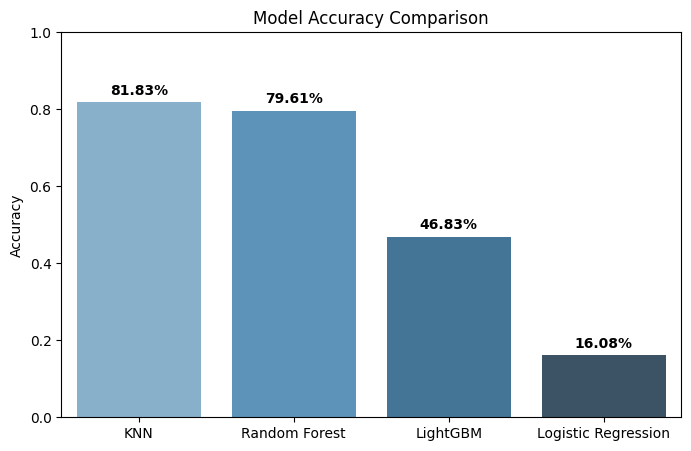

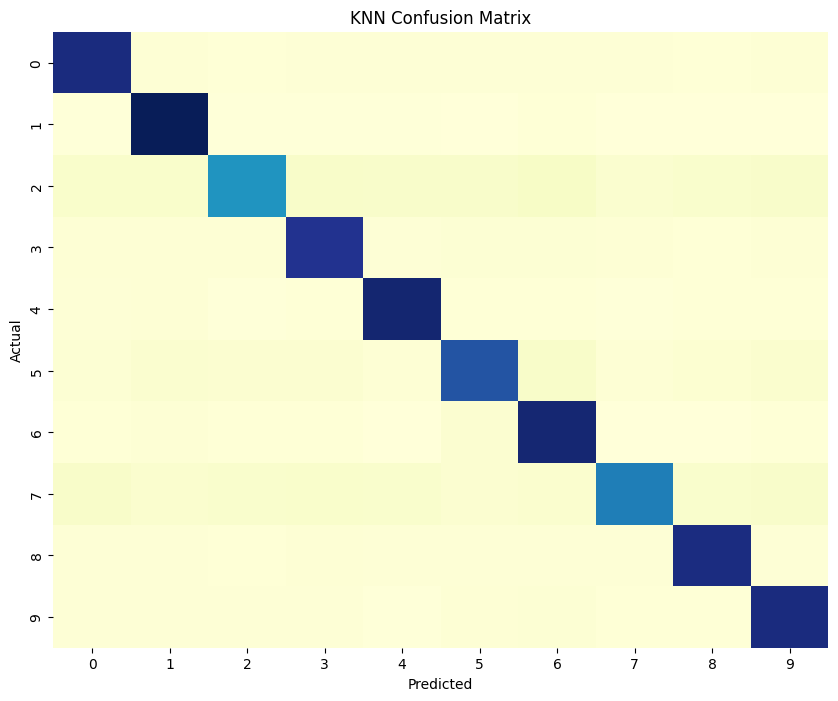

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Accuracy Bar Chart ---
models = ["KNN", "Random Forest", "LightGBM", "Logistic Regression"]
accuracies = [
    accuracy_score(y_test, y_pred),       # KNN
    accuracy_score(y_test, rf_pred),
    accuracy_score(y_test, lgb_pred),
    accuracy_score(y_test, lr_pred)
]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=accuracies, palette="Blues_d")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontweight='bold')
plt.show()

# --- Confusion Matrix for KNN (best model) ---
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="YlGnBu", cbar=False)
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [6]:
import joblib

# Save both the model and the scaler
joblib.dump(best_knn, "../models/knn_model_boston.pkl")
joblib.dump(scaler, "../models/scaler_boston.pkl")

print("KNN model and scaler saved successfully!")


KNN model and scaler saved successfully!


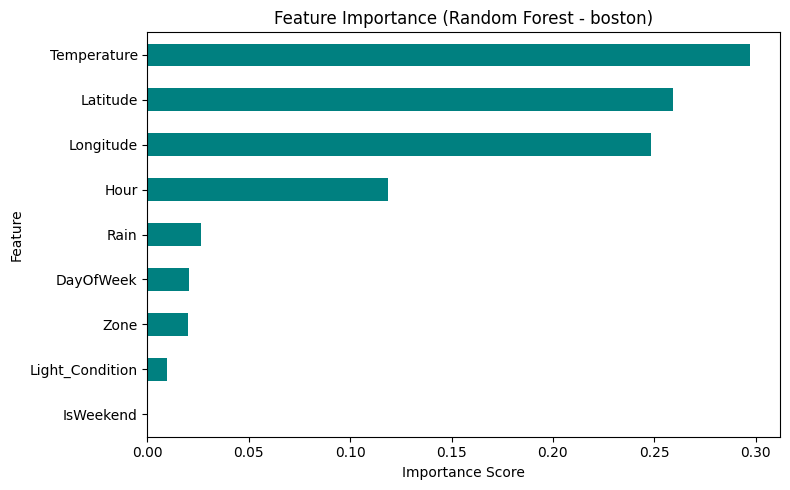

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Get importance scores
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=True)

# Plot
plt.figure(figsize=(8,5))
feat_imp.plot(kind='barh', color='teal')
plt.title("Feature Importance (Random Forest - boston)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [9]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=target_le.classes_, columns=target_le.classes_)
cm_df["Most Confused With"] = cm_df.apply(lambda row: row.drop(row.name).idxmax(), axis=1)
print("Top Confusions:")
print(cm_df["Most Confused With"].head(10))


Top Confusions:
ASSAULT - SIMPLE                                                                   VANDALISM
DRUGS - POSSESSION/ SALE/ MANUFACTURING/ USE                        PROPERTY - LOST/ MISSING
INVESTIGATE PERSON                                                  PROPERTY - LOST/ MISSING
INVESTIGATE PROPERTY                                                PROPERTY - LOST/ MISSING
LARCENY SHOPLIFTING                             DRUGS - POSSESSION/ SALE/ MANUFACTURING/ USE
M/V - LEAVING SCENE - PROPERTY DAMAGE                               PROPERTY - LOST/ MISSING
PROPERTY - LOST/ MISSING                               M/V - LEAVING SCENE - PROPERTY DAMAGE
SICK ASSIST                                                                 ASSAULT - SIMPLE
TOWED MOTOR VEHICLE                                                     INVESTIGATE PROPERTY
VANDALISM                                                           PROPERTY - LOST/ MISSING
Name: Most Confused With, dtype: object


In [10]:
import folium
from folium.plugins import HeatMap

# Create a map centered around Chicago
m = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=11)

# Add a heatmap layer
HeatMap(data=df[['Latitude', 'Longitude']], radius=10, blur=15).add_to(m)

m.save("chicago_crime_heatmap.html")
print("✅ Saved interactive heatmap: chicago_crime_heatmap.html")


/Users/prateek/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


✅ Saved interactive heatmap: chicago_crime_heatmap.html
